In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  9 23:28:04 2023

@author: dinglin
"""

import ray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import math
import random
import string
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
train_data_dir = "./data/train_data.npy"
test_data_dir = "./data/test_data.npy"

CLIENT_NUM = 100
E = 10
C = 0.10
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

In [3]:
train_data = np.load(train_data_dir, allow_pickle=True)
test_data = np.load(test_data_dir, allow_pickle=True)

In [4]:
def partition_data(idx):
    # Preprocessing
    local_data = train_data[idx]
    local_data["images"] = [image.flatten() for image in local_data["images"]]
    train_images, val_images, train_labels, val_labels = train_test_split(
    local_data["images"], local_data["labels"], test_size=0.2, random_state=42)
    return [train_images, val_images, train_labels, val_labels]

In [5]:
import copy
def add_noise(train_images, b = 1):
    image_size = np.size(train_images[0])
    for i in range(len(train_images)):
        train_images[i] += np.random.laplace(0,b,image_size)
    return train_images

def partition_data(idx, b = 1):
    # Preprocessing
    local_data = train_data[idx]
    local_data["images"] = [image.flatten() for image in local_data["images"]]
    train_images, val_images, train_labels, val_labels = train_test_split(
    local_data["images"], local_data["labels"], test_size=0.2, random_state=42)
    #train_images = add_noise(train_images, b)
    return [train_images, val_images, train_labels, val_labels]

def perturb_data(data, b = 1):
    new_data = copy.deepcopy(data)
    train_images = new_data[0]
    valid_images = new_data[1]
    train_images = add_noise(train_images, b)
    valid_images = add_noise(valid_images, b)
    new_data[0] = train_images
    new_data[1] = valid_images
    return new_data

In [6]:
class MLP2(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(MLP2, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [7]:
def weighted_average(weights, client_results):
    loss_list = [weights[i]*client_results[i][0] for i in range(len(client_results))]
    acc_list = [weights[i]*client_results[i][1] for i in range(len(client_results))]
    return sum(loss_list)/sum(weights), sum(acc_list)/sum(weights)

def fedAvg(weights, train_results):
    models_weights = [train_results[i][2] for i in range(len(train_results))]
    weighted_averaged_weights = {}
    for param_name in models_weights[0]:
        param_tensors = [model[param_name] for model in models_weights]
        weighted_averaged_param = sum(weight * param / sum(weights) for weight, param in zip(weights, param_tensors))
        weighted_averaged_weights[param_name] = weighted_averaged_param
    return weighted_averaged_weights 

In [8]:
def train_model(model, data, E):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    criterion = nn.CrossEntropyLoss()
    x_train = np.array(data[0])
    y_train = np.array(data[2])
    idxes = [i for i in range(len(y_train))]
    shuffled_list = random.sample(idxes, len(idxes))
    batch_idx = [shuffled_list[i:min(i+32,len(idxes))] for i in range(0, len(idxes), 32)]
    for e in range(E):
        total_correct = 0
        for b in range(len(batch_idx)):
            optimizer.zero_grad()
            bid = batch_idx[b]
            batch_x = x_train[bid]
            batch_y = y_train[bid]
        
            inputs = torch.FloatTensor(batch_x).to(device)
            labels = torch.tensor(batch_y,dtype=torch.int64).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total_correct += correct

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #return loss.item(), total_correct/len(self.y_val), [self.model.layer1.weight, self.model.layer2.weight]
    return loss.item(), total_correct/len(y_train), model.state_dict()
    
def validate_model(model, data, log_view = False):
    x_val = data[0]
    y_val = data[1]
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        inputs = torch.FloatTensor(x_val).to(device)
        outputs = model(inputs) 
        labels = torch.tensor(y_val,dtype=torch.int64).to(device)
        val_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct = (predicted == labels).sum().item()
        if log_view:
            print("total correct/ num_samples:", total_correct, len(y_val))
    return val_loss.item(), total_correct/len(y_val)

In [10]:
def fedavg_sim(C=0.1, E=1, b=1):
    data = [partition_data(i,b) for i in range(CLIENT_NUM)]
    weights = np.array([len(data[i][2]) for i in range(CLIENT_NUM)])
    weights = weights/sum(weights)
    clients = [MLP2(28*28, 62).to(device) for i in range(CLIENT_NUM)]
    servel_model = MLP2(28*28, 62).to(device)
    fed_results_10 = np.zeros((15000,4))
    for idx in range(CLIENT_NUM):
        data[idx] = data_idx = perturb_data(data[idx], b)
    for i in range(15000):
        sample_clients_id = random.sample([i for i in range(CLIENT_NUM)], int(CLIENT_NUM*C))
        weight_iter = weights[sample_clients_id]
        weight_iter = weight_iter/sum(weight_iter)
        train_results = []
        valid_results = []
        for idx in sample_clients_id:
            model_idx = clients[idx]
            data_idx = data[idx]
            #data_idx = perturb_data(data_idx, b = 1)
            train_results_idx = train_model(model_idx, data_idx, E)
            train_results.append(train_results_idx)
            valid_results_idx = validate_model(model_idx, [data_idx[1], data_idx[3]])
            valid_results.append(valid_results_idx)
        w_train_results = weighted_average(weight_iter, train_results)
        w_valid_results = weighted_average(weight_iter, valid_results)
        new_weights = fedAvg(weight_iter, train_results)
        for client in clients:
            client.load_state_dict(new_weights)
        fed_results_10[i,0] = w_train_results[0]
        fed_results_10[i,1] = w_train_results[1]
        fed_results_10[i,2] = w_valid_results[0]
        fed_results_10[i,3] = w_valid_results[1]
        if i%100 == 0:
            np.save("./fed_c{}e{}b{}.npy".format(int(C*100),E,b), fed_results_10)
        if i%500 == 0:
            print("Episode: {}".format(i) , "Training Loss: {}".format(fed_results_10[i,0]), "Training Accuracy: {}".format(fed_results_10[i,1]))
            print("Episode: {}".format(i) , "Validation Loss: {}".format(fed_results_10[i,2]), "Validation Accuracy: {}".format(fed_results_10[i,3]))
            target_model = clients[0]
            torch.save(target_model.state_dict(), './model/fed_c{}e{}b{}.pth'.format(int(C*100),E,b))
    return clients[0]

In [8]:
## Old Version
def fedavg_sim(C=0.1, E=1):
    data = [partition_data(i) for i in range(CLIENT_NUM)]
    weights = np.array([len(data[i][2]) for i in range(CLIENT_NUM)])
    weights = weights/sum(weights)
    clients = [MLP2(28*28, 62).to(device) for i in range(CLIENT_NUM)]
    servel_model = MLP2(28*28, 62).to(device)
    fed_results_10 = np.zeros((15000,4))
    for i in range(15000):
        sample_clients_id = random.sample([i for i in range(CLIENT_NUM)], int(CLIENT_NUM*C))
        weight_iter = weights[sample_clients_id]
        weight_iter = weight_iter/sum(weight_iter)
        train_results = []
        valid_results = []
        for idx in sample_clients_id:
            model_idx = clients[idx]
            data_idx = data[idx]
            train_results_idx = train_model(model_idx, data_idx, E)
            train_results.append(train_results_idx)
            valid_results_idx = validate_model(model_idx, [data_idx[1], data_idx[3]])
            if i%10==0 and idx == sample_clients_id[0]:
                valid_results_idx = validate_model(model_idx, [data_idx[1], data_idx[3]],True)
            valid_results.append(valid_results_idx)
        w_train_results = weighted_average(weight_iter, train_results)
        w_valid_results = weighted_average(weight_iter, valid_results)
        new_weights = fedAvg(weight_iter, train_results)
        for client in clients:
            client.load_state_dict(new_weights)
        fed_results_10[i,0] = w_train_results[0]
        fed_results_10[i,1] = w_train_results[1]
        fed_results_10[i,2] = w_valid_results[0]
        fed_results_10[i,3] = w_valid_results[1]
        if i%100 == 0:
            np.save("./fed_c{}e{}.npy".format(int(C*100),E), fed_results_10)
        if i%100 == 0:
            print("Episode: {}".format(i) , "Training Loss: {}".format(fed_results_10[i,0]), "Training Accuracy: {}".format(fed_results_10[i,1]))
            print("Episode: {}".format(i) , "Validation Loss: {}".format(fed_results_10[i,2]), "Validation Accuracy: {}".format(fed_results_10[i,3]))
    target_model = clients[0]
    torch.save(target_model.state_dict(), './model/fed_c{}e{}.pth'.format(int(C*100),E))
    return clients[0]

## Scale b = 1

In [12]:
fedavg_sim(C=0.1,E=1,b=0)

Episode: 0 Training Loss: 4.099454951362488 Training Accuracy: 0.02795527156549521
Episode: 0 Validation Loss: 4.0837352942354 Validation Accuracy: 0.04284305533426418
Episode: 500 Training Loss: 3.187254663794469 Training Accuracy: 0.15887850467289721
Episode: 500 Validation Loss: 3.2261246282460485 Validation Accuracy: 0.15792072676421007
Episode: 1000 Training Loss: 1.9134828414924407 Training Accuracy: 0.41057542768273714
Episode: 1000 Validation Loss: 2.078947603702545 Validation Accuracy: 0.4405647588576139
Episode: 1500 Training Loss: 1.5616579887307722 Training Accuracy: 0.5949074074074074
Episode: 1500 Validation Loss: 1.547153169818131 Validation Accuracy: 0.5810692807325858
Episode: 2000 Training Loss: 1.397465722149252 Training Accuracy: 0.6288826139572408
Episode: 2000 Validation Loss: 1.4902137151982047 Validation Accuracy: 0.5993443336294489
Episode: 2500 Training Loss: 1.0699113663737339 Training Accuracy: 0.6603392568659127
Episode: 2500 Validation Loss: 1.319813799756

MLP2(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=62, bias=True)
)

In [11]:
fedavg_sim(C=0.1,E=1,b=0.05)

/tmp/ipykernel_955058/2890462092.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020195/work/torch/csrc/utils/tensor_new.cpp:261.)
  inputs = torch.FloatTensor(x_val).to(device)


Episode: 0 Training Loss: 4.104490347297415 Training Accuracy: 0.021017234131988232
Episode: 0 Validation Loss: 4.106956982422196 Validation Accuracy: 0.03666194932319082
Episode: 500 Training Loss: 3.3129439899591895 Training Accuracy: 0.13902439024390245
Episode: 500 Validation Loss: 3.2106703715595777 Validation Accuracy: 0.12244786760695356
Episode: 1000 Training Loss: 2.216921048524451 Training Accuracy: 0.40007627765064835
Episode: 1000 Validation Loss: 2.196301837898592 Validation Accuracy: 0.3945438421374466
Episode: 1500 Training Loss: 1.4827439135480152 Training Accuracy: 0.5921495327102805
Episode: 1500 Validation Loss: 1.944906685686557 Validation Accuracy: 0.5042837540011418
Episode: 2000 Training Loss: 1.1738213560834783 Training Accuracy: 0.6049580167932826
Episode: 2000 Validation Loss: 1.5473669879868333 Validation Accuracy: 0.5624465719164017
Episode: 2500 Training Loss: 1.3002957418727765 Training Accuracy: 0.6781165573137784
Episode: 2500 Validation Loss: 1.45906582

MLP2(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=62, bias=True)
)

In [10]:
fedavg_sim(C=0.1,E=1,b=0.1)

/tmp/ipykernel_906152/473478640.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020195/work/torch/csrc/utils/tensor_new.cpp:261.)
  inputs = torch.FloatTensor(x_val).to(device)


Episode: 0 Training Loss: 4.107824746209013 Training Accuracy: 0.023567655424624138
Episode: 0 Validation Loss: 4.103696161825838 Validation Accuracy: 0.02579840086561451
Episode: 500 Training Loss: 3.7060201159981747 Training Accuracy: 0.06014400677678951
Episode: 500 Validation Loss: 3.7066860888681896 Validation Accuracy: 0.07230817472425384
Episode: 1000 Training Loss: 3.349737911371635 Training Accuracy: 0.1206176961602671
Episode: 1000 Validation Loss: 3.303700046865689 Validation Accuracy: 0.1489080863615446
Episode: 1500 Training Loss: 2.723842479233875 Training Accuracy: 0.28928046989721
Episode: 1500 Validation Loss: 2.6497104077787306 Validation Accuracy: 0.2713815507168383
Episode: 2000 Training Loss: 2.0471922592598535 Training Accuracy: 0.428068803752932
Episode: 2000 Validation Loss: 2.1794787668641233 Validation Accuracy: 0.39749726789200157
Episode: 2500 Training Loss: 1.747783417644955 Training Accuracy: 0.5166666666666667
Episode: 2500 Validation Loss: 1.869373262590

IndexError: index 15000 is out of bounds for axis 0 with size 15000

In [12]:
fedavg_sim(C=0.1,E=1,b=0.2)

Episode: 0 Training Loss: 4.090399902170887 Training Accuracy: 0.02803379416282642
Episode: 0 Validation Loss: 4.094142079536449 Validation Accuracy: 0.04418481459867003
Episode: 500 Training Loss: 3.726024829594776 Training Accuracy: 0.05131313131313131
Episode: 500 Validation Loss: 3.738937277264066 Validation Accuracy: 0.06898050433440985
Episode: 1000 Training Loss: 3.0188877707734028 Training Accuracy: 0.10660302307080351
Episode: 1000 Validation Loss: 3.4519597346951496 Validation Accuracy: 0.13110292678501795
Episode: 1500 Training Loss: 2.834791974991745 Training Accuracy: 0.2732919254658385
Episode: 1500 Validation Loss: 2.806928989032041 Validation Accuracy: 0.23207005168835124
Episode: 2000 Training Loss: 2.499568412350302 Training Accuracy: 0.34656609765780066
Episode: 2000 Validation Loss: 2.541593001067709 Validation Accuracy: 0.3416961830775822
Episode: 2500 Training Loss: 2.043210949107796 Training Accuracy: 0.412375249500998
Episode: 2500 Validation Loss: 2.30423240247

MLP2(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=62, bias=True)
)

In [13]:
fedavg_sim(C=0.1,E=1,b=0.5)

Episode: 0 Training Loss: 4.099236477243993 Training Accuracy: 0.014291547570436913
Episode: 0 Validation Loss: 4.0957754821668315 Validation Accuracy: 0.02914825292006353
Episode: 500 Training Loss: 3.2586751973207027 Training Accuracy: 0.11799410029498526
Episode: 500 Validation Loss: 3.3609783060431133 Validation Accuracy: 0.12141478979047612
Episode: 1000 Training Loss: 3.025624584486453 Training Accuracy: 0.2385766275778407
Episode: 1000 Validation Loss: 3.067898712416578 Validation Accuracy: 0.1754189361828636
Episode: 1500 Training Loss: 2.763120008986207 Training Accuracy: 0.3275316455696202
Episode: 1500 Validation Loss: 3.007036630111404 Validation Accuracy: 0.20212610847129833
Episode: 2000 Training Loss: 2.1226390921306932 Training Accuracy: 0.4500561167227834
Episode: 2000 Validation Loss: 2.9248846656501053 Validation Accuracy: 0.27556454442311845
Episode: 2500 Training Loss: 1.7884197615140205 Training Accuracy: 0.49286280729579696
Episode: 2500 Validation Loss: 3.346097

MLP2(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=62, bias=True)
)

In [ ]:
fedavg_sim(C=0.1,E=1,b=1)

Episode: 0 Training Loss: 4.106092788380146 Training Accuracy: 0.015768243491015767
Episode: 0 Validation Loss: 4.089198993945847 Validation Accuracy: 0.029084388483584918
Episode: 500 Training Loss: 3.4490609547211757 Training Accuracy: 0.10268678689731321
Episode: 500 Validation Loss: 3.521889455273698 Validation Accuracy: 0.10217953967005561
Episode: 1000 Training Loss: 3.1978269633158893 Training Accuracy: 0.19296116504854371
Episode: 1000 Validation Loss: 3.50621996265399 Validation Accuracy: 0.11053294798201883
Episode: 1500 Training Loss: 2.6200765880435637 Training Accuracy: 0.3545527800161161
Episode: 1500 Validation Loss: 3.7835517862359915 Validation Accuracy: 0.10062534294296074
Episode: 2000 Training Loss: 1.733866983837024 Training Accuracy: 0.5752585216392188
Episode: 2000 Validation Loss: 5.3893340018369935 Validation Accuracy: 0.09003035422385623
Episode: 2500 Training Loss: 1.3069771326873865 Training Accuracy: 0.7112485504445305
Episode: 2500 Validation Loss: 6.81083

## Plotting

In [1]:
import matplotlib.pyplot as plt

def plot_curve(results):
    epochs = [i for i in range(1,np.size(results,0)+1)]
    train_loss = results[:,0]
    train_accuracy = results[:,1]
    val_loss = results[:,2]
    val_accuracy = results[:,3]
    
    # Create a 2x2 subplot setting
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot Training Loss
    axs[0, 0].plot(epochs, train_loss, label='Training Loss')
    axs[0, 0].set_title('Training Loss')
    axs[0, 0].set_xlabel('Communication Rounds')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plot Training Accuracy
    axs[0, 1].plot(epochs, train_accuracy, label='Training Accuracy')
    axs[0, 1].set_title('Training Accuracy')
    axs[0, 1].set_xlabel('Communication Rounds')
    axs[0, 1].set_ylabel('Accuracy (%)')
    axs[0, 1].legend()
    
    # Plot Validation Loss
    axs[1, 0].plot(epochs, val_loss, label='Validation Loss')
    axs[1, 0].set_title('Validation Loss')
    axs[1, 0].set_xlabel('Communication Rounds')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    # Plot Validation Accuracy
    axs[1, 1].plot(epochs, val_accuracy, label='Validation Accuracy')
    axs[1, 1].set_title('Validation Accuracy')
    axs[1, 1].set_xlabel('Communication Rounds')
    axs[1, 1].set_ylabel('Accuracy (%)')
    axs[1, 1].legend()

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

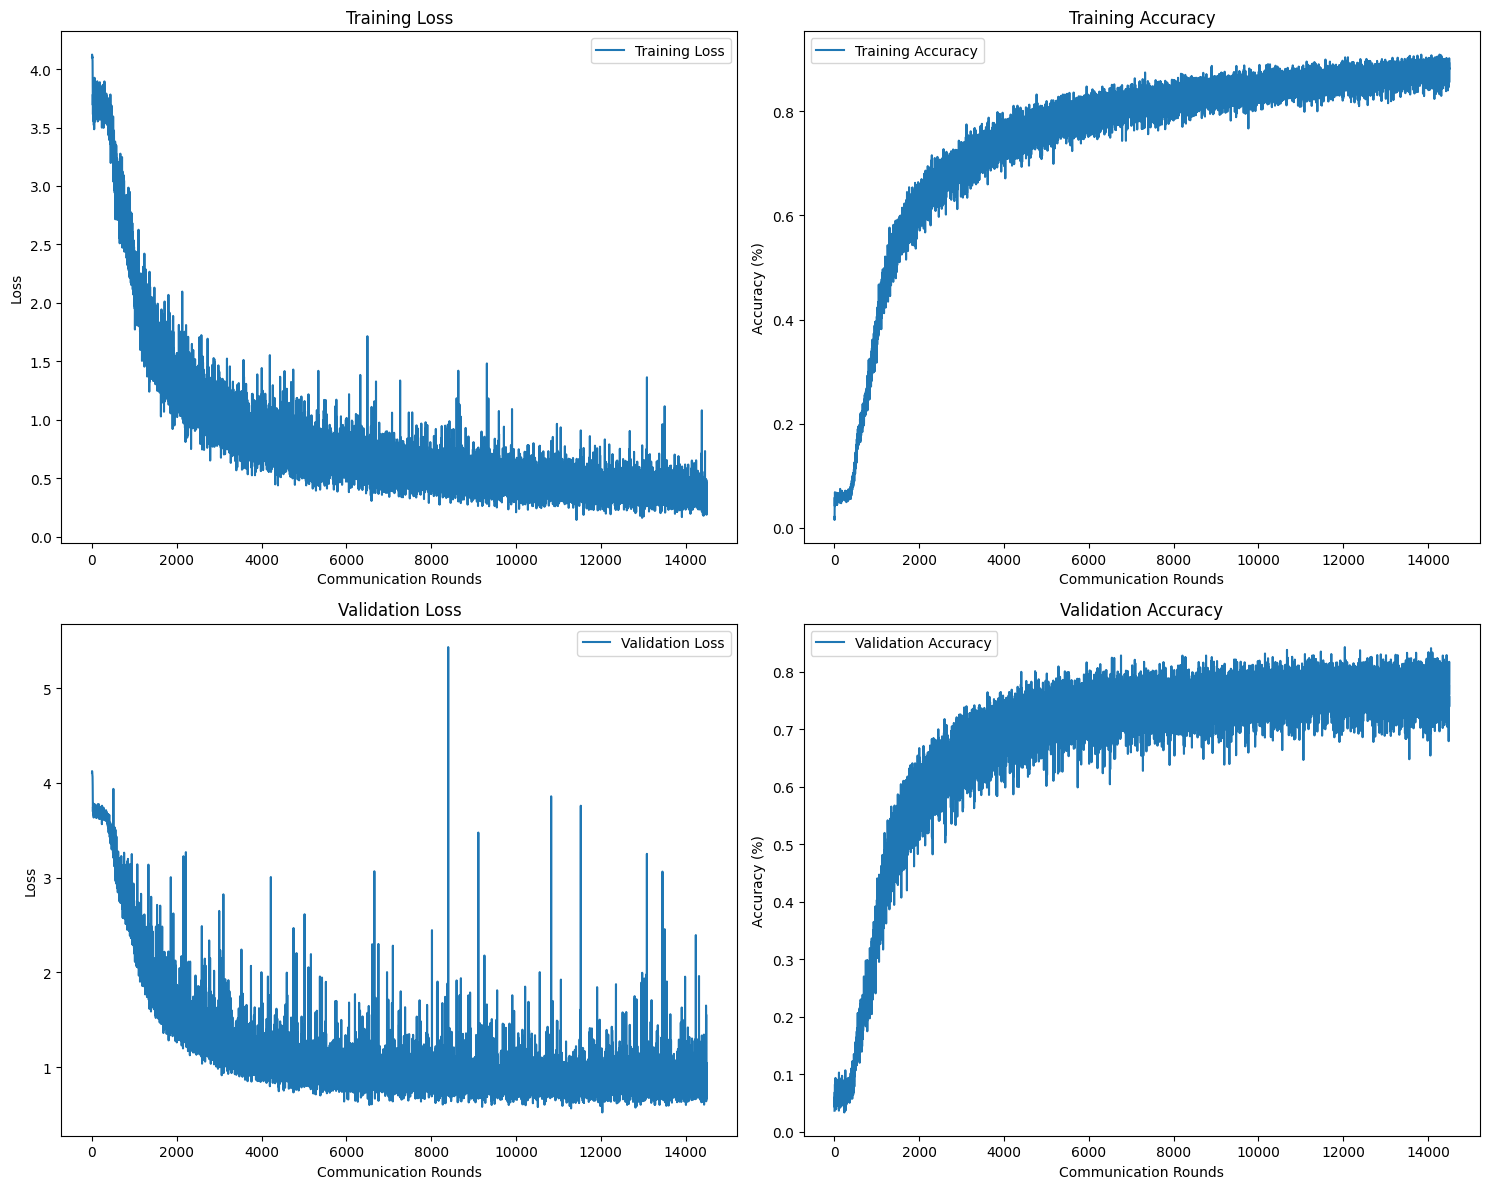

In [12]:
central_results = np.load("./fed_c10e1b0.05.npy")[0:14500]
plot_curve(central_results)

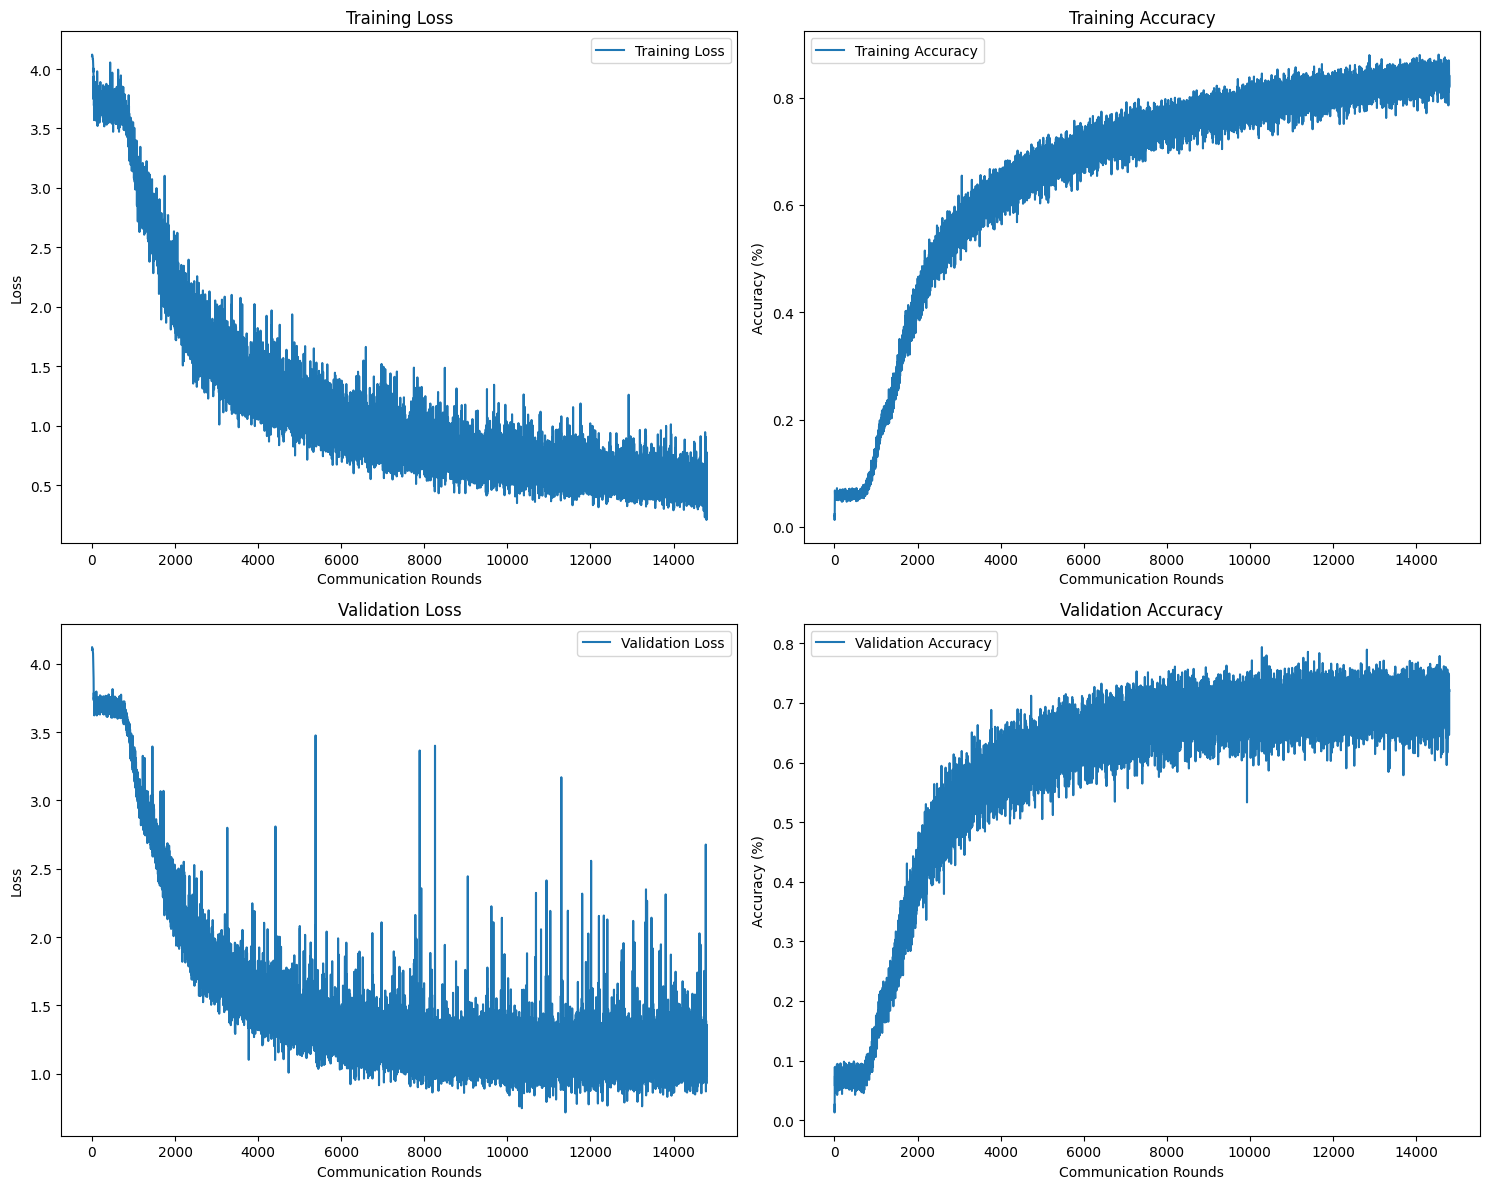

In [8]:
central_results = np.load("./fed_c10e1b0.1.npy")[0:14800]
plot_curve(central_results)

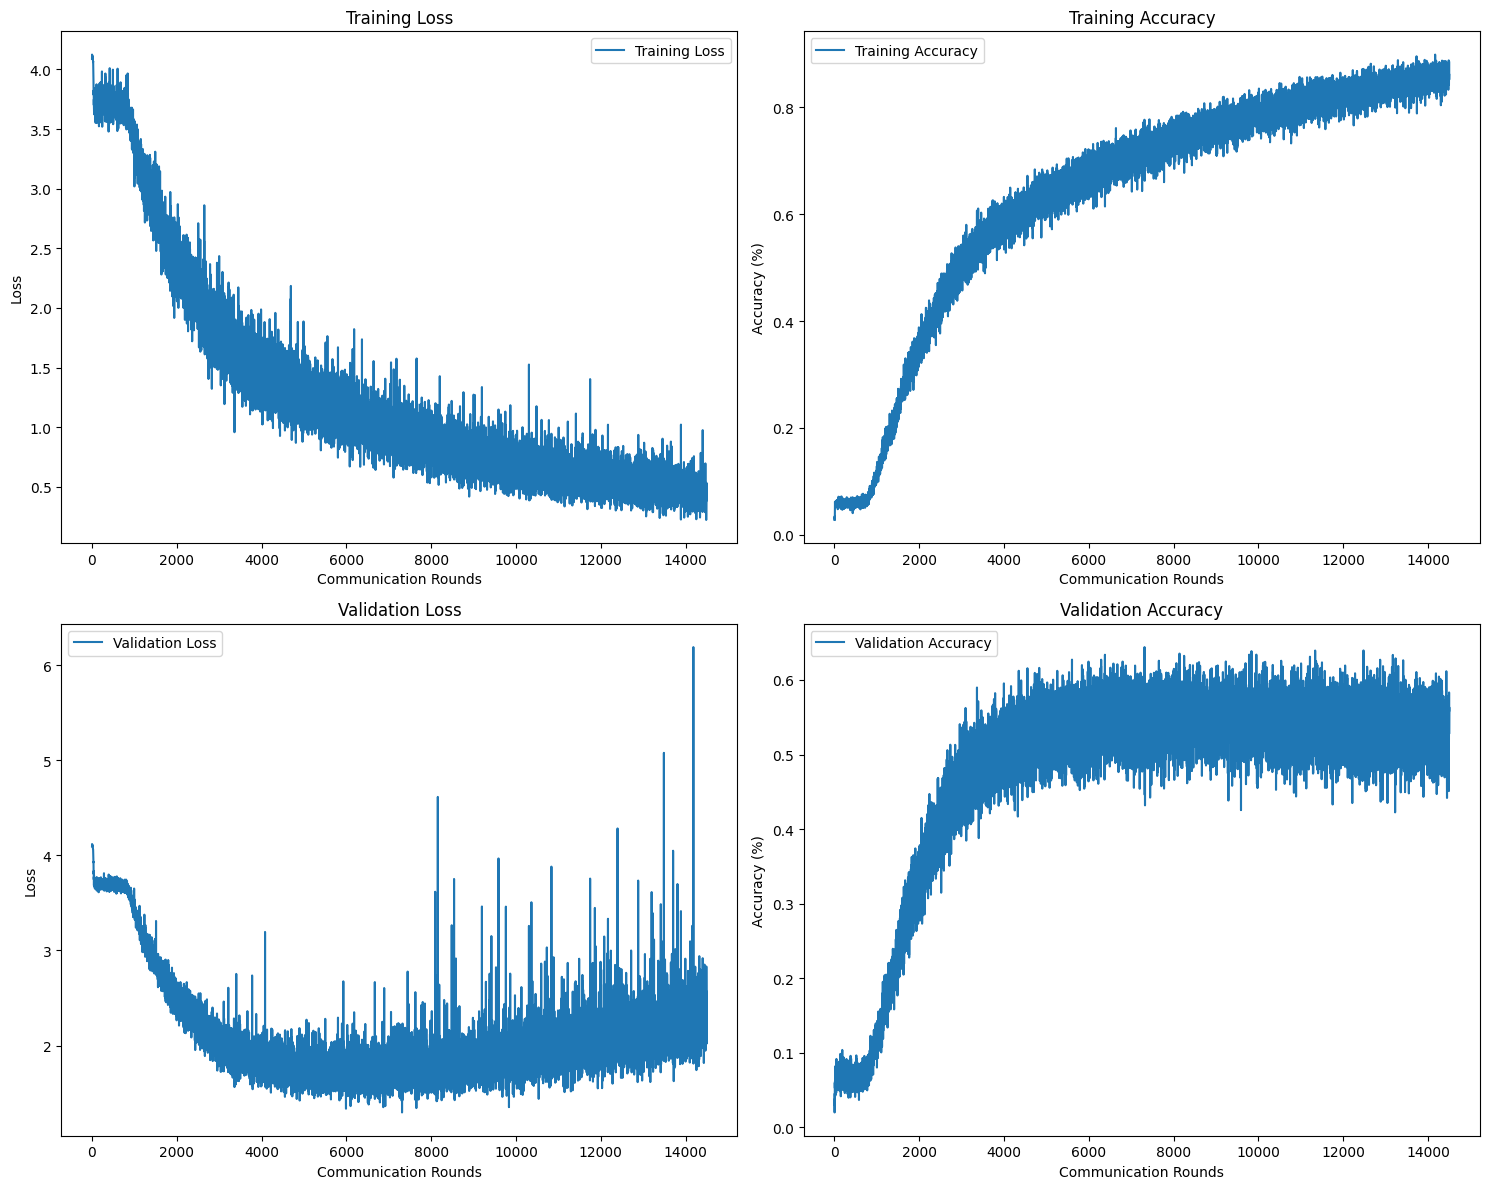

In [11]:
central_results = np.load("./fed_c10e1b0.2.npy")[0:14500]
plot_curve(central_results)

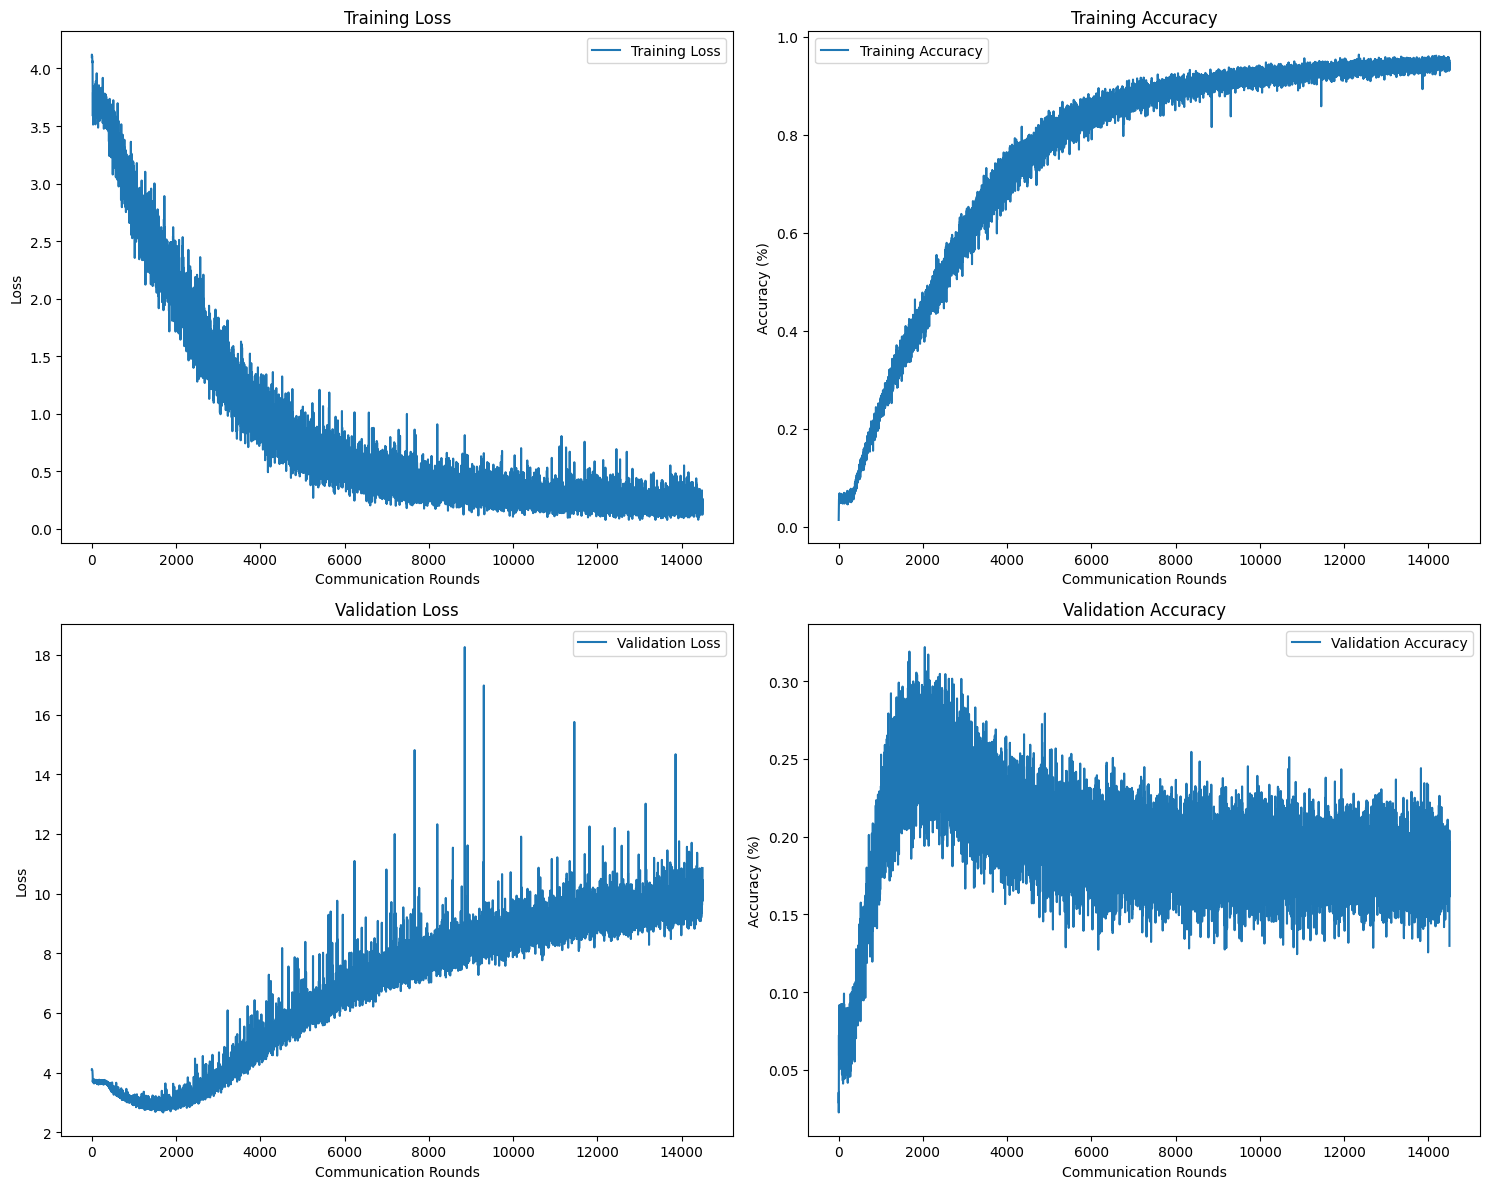

In [10]:
central_results = np.load("./fed_c10e1b0.5.npy")[0:14500]
plot_curve(central_results)

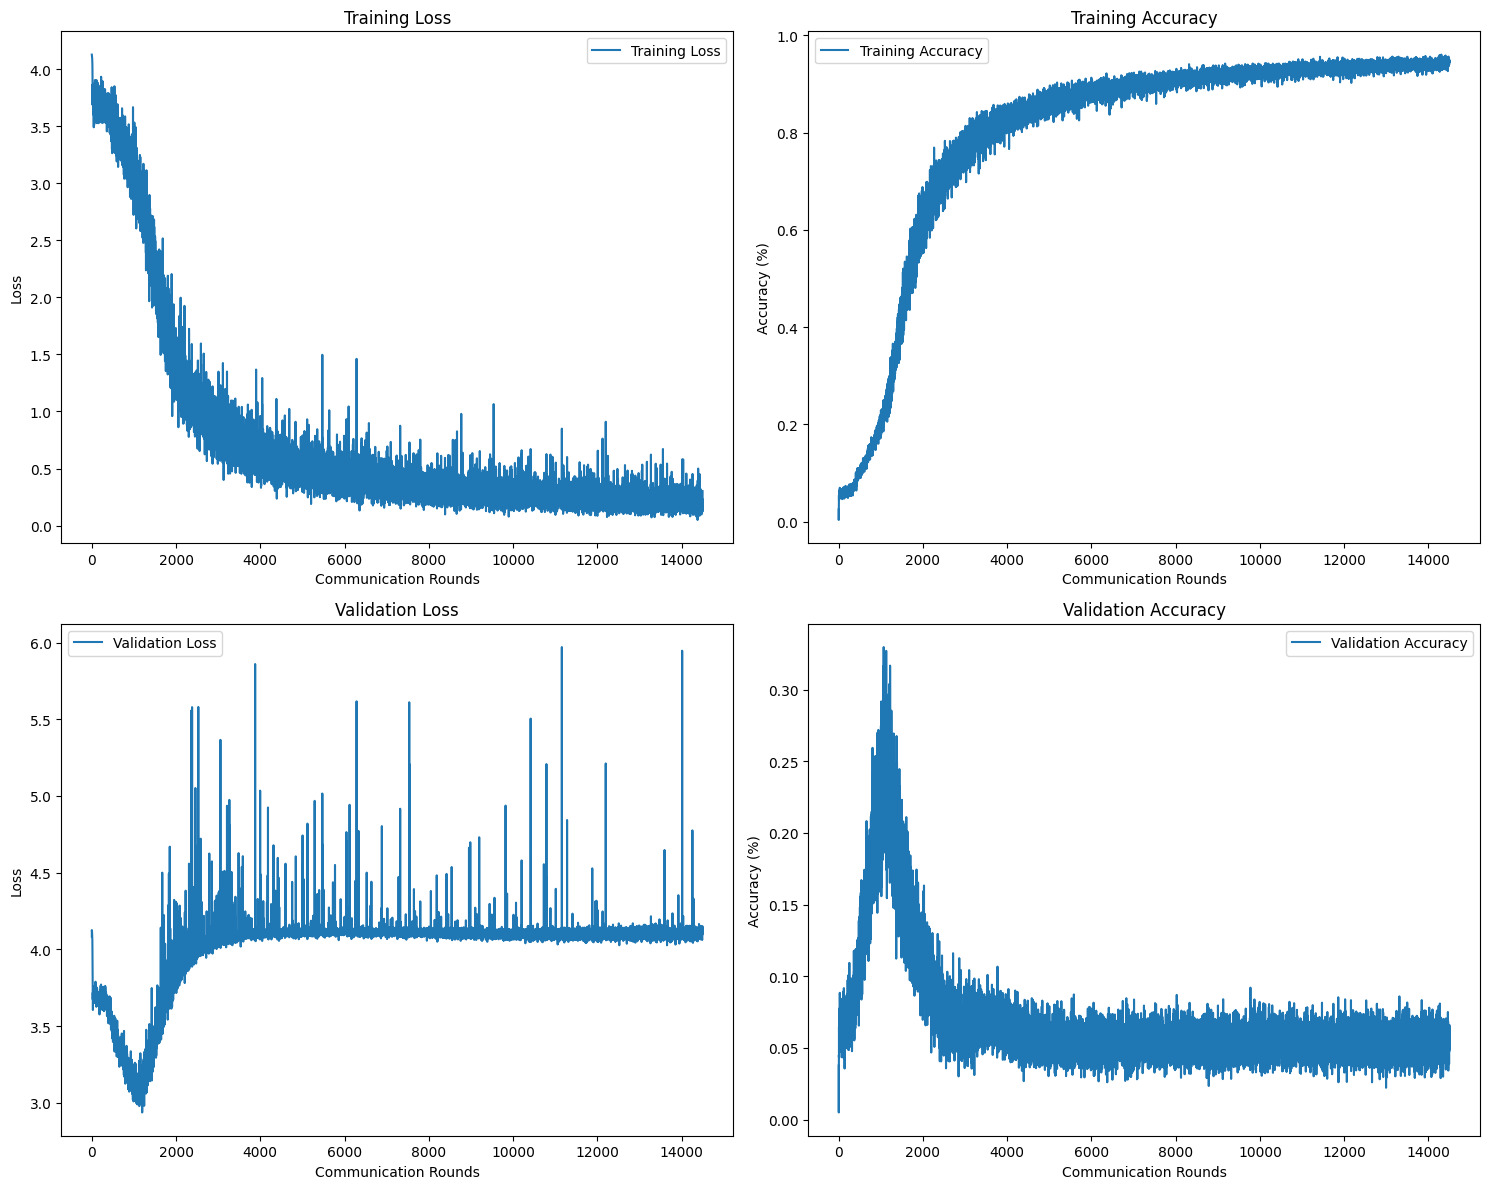

In [9]:
central_results = np.load("./fed_c10e1b0.25.npy")[0:14500]
plot_curve(central_results)

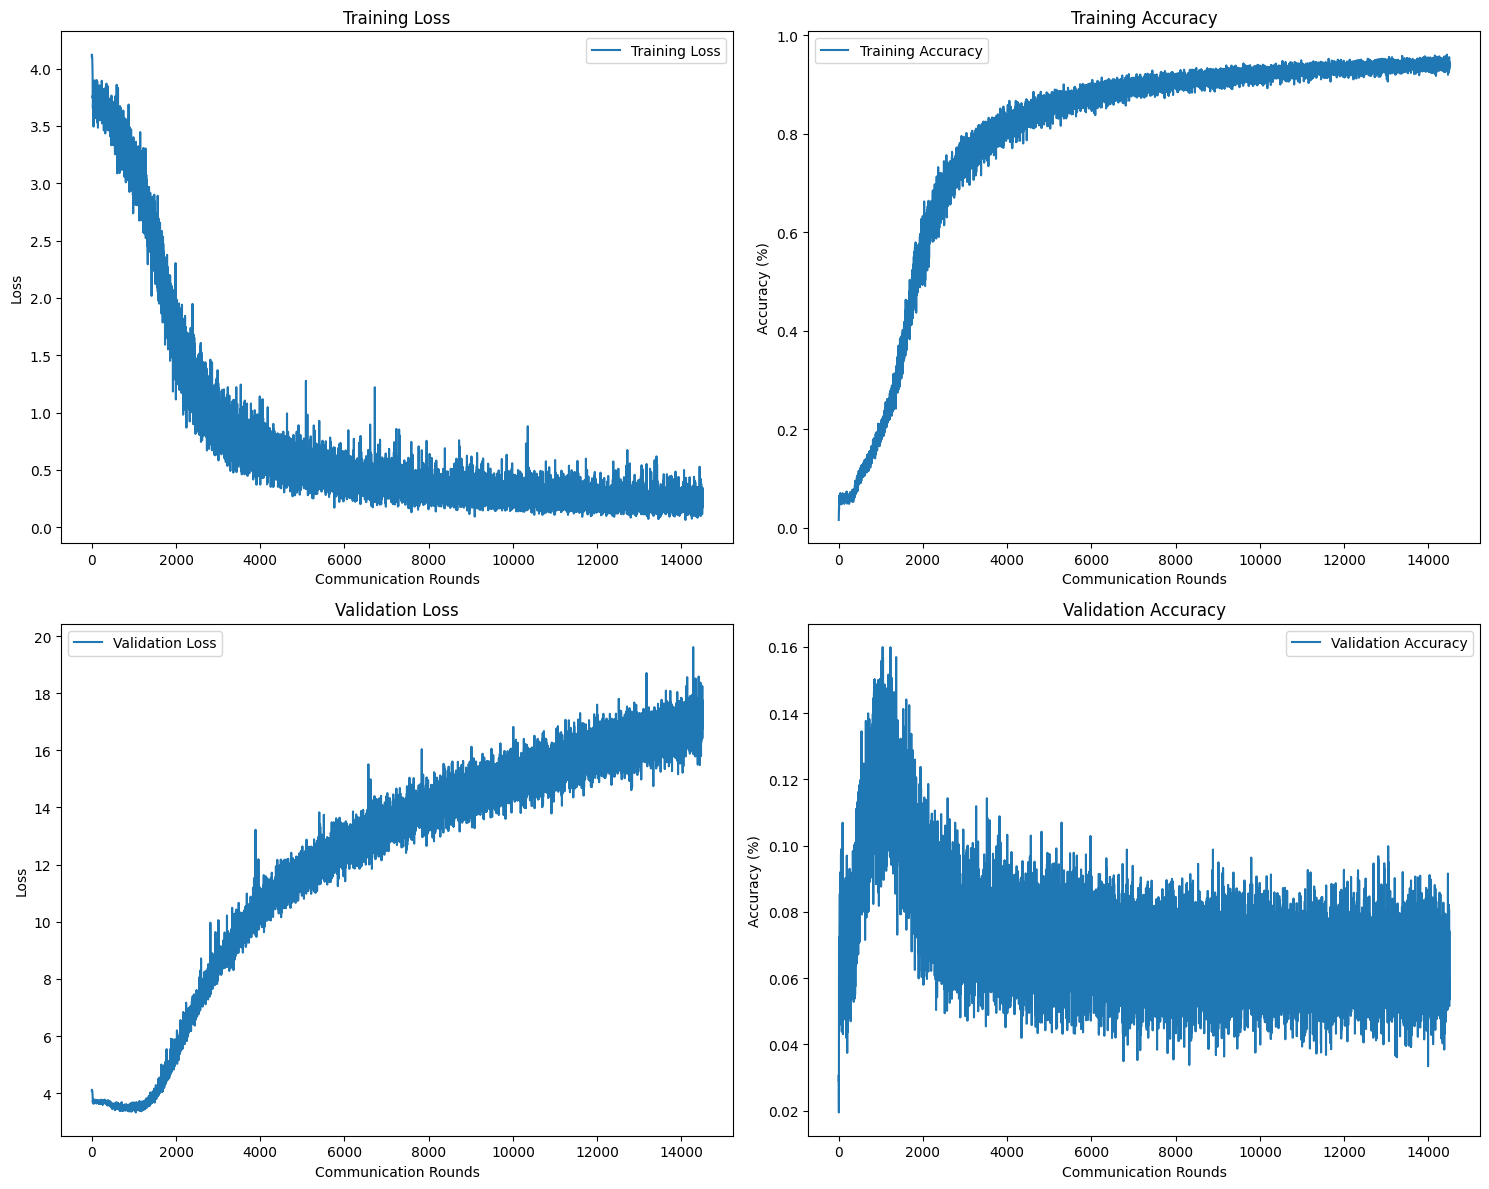

In [3]:
import numpy as np
central_results = np.load("./fed_c10e1b1.npy")[0:14500]
plot_curve(central_results)